In [14]:
!pip install gluoncv

You are using pip version 10.0.1, however version 19.2.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [15]:
from gluoncv import model_zoo, data, utils
from matplotlib import pyplot as plt
import cv2
import glob
import boto3
import re
import sagemaker
from sagemaker import get_execution_role
import time
from time import gmtime, strftime
import json
import numpy as np
import os
import gluoncv as gcv
from gluoncv.utils import download, viz


role = get_execution_role()
sess = sagemaker.Session()
s3 = boto3.resource('s3')

In [16]:
def noisy(noise_typ,image):
    if noise_typ == "gauss":
        row,col,ch= image.shape
        mean = 0
        var = 0.1
        sigma = var**0.5
        gauss = np.random.normal(mean,sigma,(row,col,ch))
        gauss = gauss.reshape(row,col,ch)
        noisy = image + gauss
        return noisy
    elif noise_typ == "s&p":
        row,col,ch = image.shape
        s_vs_p = 0.5
        amount = 0.01
        out = np.copy(image)
        # Salt mode
        num_salt = np.ceil(amount * image.size * s_vs_p)
        coords = [np.random.randint(0, i - 1, int(num_salt))
              for i in image.shape]
        out[coords] = 1

        # Pepper mode
        num_pepper = np.ceil(amount* image.size * (1. - s_vs_p))
        coords = [np.random.randint(0, i - 1, int(num_pepper))
              for i in image.shape]
        out[coords] = 0
        return out
    elif noise_typ == "poisson":
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return noisy
    elif noise_typ =="speckle":
        row,col,ch = image.shape
        gauss = np.random.randn(row,col,ch)
        gauss = gauss.reshape(row,col,ch)        
        noisy = image + image * 0.3 * gauss
        return noisy
    
def adjust_gamma(image, gamma=1.0):

    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
        for i in np.arange(0, 256)]).astype("uint8")

    return cv2.LUT(image, table)

In [17]:
import glob
import cv2

!mkdir gt-input
!aws s3 sync s3://ale-golfball-train/gt-input/ ./gt-input

in_images = glob.glob("./gt-input/*.jpeg")

image_shape = 320
scale = image_shape / 850
#base_network = "vgg-16"
base_network = "resnet-50"

mkdir: cannot create directory ‘gt-input’: File exists


In [18]:
if not os.path.exists("gt-input-small " + str(image_shape)):
    !rm gt-input-small$image_shape -R
    !mkdir gt-input-small$image_shape

    for f in in_images:
        image = cv2.imread(f)
        image = cv2.resize(image,None,fx=scale,fy=scale)
        #print(f.replace("gt-input", "gt-input-small"))
        filename = f.replace("gt-input", "gt-input-small" + str(image_shape))

        cv2.imwrite(filename, image)
        image_grey = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY, 1)
        cv2.imwrite(filename.replace(".jpeg", "_grey.jpeg"), image_grey)
        image_noise = noisy("s&p", image)
        cv2.imwrite(filename.replace(".jpeg", "_n1.jpeg"), image_noise)
        image_noise = noisy("speckle", image)
        cv2.imwrite(filename.replace(".jpeg", "_n2.jpeg"), image_noise)
        image_dark = adjust_gamma(image, 0.5)
        cv2.imwrite(filename.replace(".jpeg", "_dark.jpeg"), image_dark)
        image_light = adjust_gamma(image, 1.9)
        cv2.imwrite(filename.replace(".jpeg", "_light.jpeg"), image_light)

        image = cv2.flip(image, flipCode=1)
        cv2.imwrite(filename.replace(".jpeg", "_vflip.jpeg"), image)
        image_dark = adjust_gamma(image, 0.5)
        cv2.imwrite(filename.replace(".jpeg", "_vflip_dark.jpeg"), image_dark)
        image_light = adjust_gamma(image, 1.9)
        cv2.imwrite(filename.replace(".jpeg", "_vflip_light.jpeg"), image_light)
    
#!aws s3 sync ./gt-input-small$image_shape s3://ale-golfball-train/gt-input-small$image_shape/

rm: cannot remove ‘gt-input-small320’: No such file or directory


In [19]:
def write_line(img_path, im_shape, boxes, ids, idx):
    h = im_shape[0]
    w = im_shape[1]
    c = im_shape[2]
    # for header, we use minimal length 2, plus width and height
    # with A: 4, B: 5, C: width, D: height
    A = 4
    B = 5
    C = w
    D = h
    # concat id and bboxes
    labels = np.hstack((ids.reshape(-1, 1), boxes)).astype('float')
    # normalized bboxes (recommanded)
    labels[:, (1, 3)] /= float(w)
    labels[:, (2, 4)] /= float(h)
    # flatten
    labels = labels.flatten().tolist()
    str_idx = [str(idx)]
    str_header = [str(x) for x in [A, B, C, D]]
    str_labels = [str(x) for x in labels]
    str_path = [img_path]
    line = '\t'.join(str_idx + str_header + str_labels + str_path) + '\n'
    return line

In [20]:
import random

augmented_manifest_filename_train = 'augmented-manifest-train-small.manifest' # Replace with the filename for your training data.
augmented_manifest_filename_validation = 'augmented-manifest-validation-small.manifest' # Replace with the filename for your validation data.
!rm $augmented_manifest_filename_train
!rm $augmented_manifest_filename_validation

s3_bucket = "ale-golfball-train"
augmented_manifest_s3_key = 'gt-output/Golfball-Label/manifests/output/output.manifest'
s3_obj = s3.Object(s3_bucket, augmented_manifest_s3_key)
augmented_manifest = s3_obj.get()['Body'].read().decode('utf-8')
augmented_manifest_lines = augmented_manifest.split('\n')

#for i in range(2):
#    print(augmented_manifest_lines[i])
    
#for i in range(len(augmented_manifest_lines)):
#    if(augmented_manifest_lines[i] == ""):
#        augmented_manifest_lines.pop(i)

random.shuffle(augmented_manifest_lines)
all_num = len(augmented_manifest_lines)
train_num = (int)(all_num * 0.8)
val_num = all_num - train_num

#print("All: " + str(all_num) + "; Train: " + str(train_num) + "; Val: " + str(val_num))

train_samples = 0

sum_hole = 0
sum_ball = 0
sum_hole_width = 0
sum_hole_height = 0 
sum_ball_width = 0
sum_ball_height = 0
for i in range(all_num):
    if(augmented_manifest_lines[i] != ""):
        augmented_manifest_lines[i]
        data = json.loads(augmented_manifest_lines[i])
        for j in range(len(data["Golfball-Label"]["annotations"])):
            if data["Golfball-Label"]["annotations"][j]["class_id"] == 1:
                sum_hole_width += data["Golfball-Label"]["annotations"][j]["width"]
                sum_hole_height += data["Golfball-Label"]["annotations"][j]["height"]
                sum_hole += 1.0
            else:
                sum_ball_width += data["Golfball-Label"]["annotations"][j]["width"]
                sum_ball_height += data["Golfball-Label"]["annotations"][j]["height"]
                sum_ball += 1.0
            
avg_hole_width = sum_hole_width / sum_hole
avg_hole_height = sum_hole_height / sum_hole
avg_ball_width = sum_ball_width / sum_ball
avg_ball_height = sum_ball_height / sum_ball

print("Hole Width: " + str(avg_hole_width))
print("Hole Height: " + str(avg_hole_height))
print("Ball Width: " + str(avg_ball_width))
print("Ball Height: " + str(avg_ball_height))

!rm output.manifest
for i in range(all_num):
    if(augmented_manifest_lines[i] != ""):
        augmented_manifest_lines[i]
        data = json.loads(augmented_manifest_lines[i])
        to_drop = []
        for j in range(len(data["Golfball-Label"]["annotations"])):
            if data["Golfball-Label"]["annotations"][j]["class_id"] == 0:
                if data["Golfball-Label"]["annotations"][j]["width"] - avg_ball_width > avg_ball_width * 0.3:
                    data["Golfball-Label"]["annotations"][j]["class_id"] = 1
                    print("Golfball too big, Covert to hole")
            if data["Golfball-Label"]["annotations"][j]["class_id"] == 1:
                if avg_hole_width - data["Golfball-Label"]["annotations"][j]["width"] > avg_ball_width * 0.4:
                    to_drop.append(data["Golfball-Label"]["annotations"][j]["width"])
                    print("Hole too small, marked: " + str(data["Golfball-Label"]["annotations"][j]["width"]))
                if avg_hole_height - data["Golfball-Label"]["annotations"][j]["height"] > avg_hole_height * 0.4:
                    to_drop.append(data["Golfball-Label"]["annotations"][j]["width"])
                    print("Hole too small (height), marked: " + str(data["Golfball-Label"]["annotations"][j]["width"]))

                    
        for j in range(len(to_drop)):
            do_drop = -1
            for k in range(len(data["Golfball-Label"]["annotations"])):
                if data["Golfball-Label"]["annotations"][k]["width"] == to_drop[j]:
                    #print("Hole too small, dropped: " + str(data["Golfball-Label"]["annotations"][k]["width"]))
                    do_drop = k
            if do_drop > -1:
                data["Golfball-Label"]["annotations"].pop(do_drop)
            
            
        with open("output.manifest", 'a') as outfile:        
            json.dump(data, outfile)
            outfile.write('\n')

Hole Width: 153.5448595654478
Hole Height: 148.7339427662957
Ball Width: 82.83200624512094
Ball Height: 82.23247462919592


In [21]:
!rm train.lst
!rm val.lst
!rm all.lst


for i in range(all_num):
    if(augmented_manifest_lines[i] != ""):
        augmented_manifest_lines[i]
        data = json.loads(augmented_manifest_lines[i])
        
        all_boxes = np.empty([0,4])
        all_ids = np.empty([0])

        data["source-ref"] = data["source-ref"].replace("gt-input", "gt-input-small" + str(image_shape))
        filename = data["source-ref"]
        data["Golfball-Label"]["image_size"][0]["width"] = int(data["Golfball-Label"]["image_size"][0]["width"] * scale)
        data["Golfball-Label"]["image_size"][0]["height"] = int(data["Golfball-Label"]["image_size"][0]["height"] * scale)
        
        for j in range(len(data["Golfball-Label"]["annotations"])):     
            data["Golfball-Label"]["annotations"][j]["width"] *= scale
            data["Golfball-Label"]["annotations"][j]["top"] *= scale
            data["Golfball-Label"]["annotations"][j]["height"] *= scale
            data["Golfball-Label"]["annotations"][j]["left"] *= scale
            xmin = data["Golfball-Label"]["annotations"][j]["left"]
            xmax = xmin + data["Golfball-Label"]["annotations"][j]["width"]
            ymin = data["Golfball-Label"]["annotations"][j]["top"]
            ymax = ymin + data["Golfball-Label"]["annotations"][j]["height"]
            all_boxes = np.concatenate((all_boxes, [[xmin, ymin, xmax, ymax]]), axis=0)
            all_ids = np.append(all_ids, [int(data["Golfball-Label"]["annotations"][j]["class_id"])])

        lst_file = data["source-ref"].replace("s3://ale-golfball-train/", "")
        with open("all.lst", 'a') as outfile:
            line = write_line(lst_file, [data["Golfball-Label"]["image_size"][0]["height"], data["Golfball-Label"]["image_size"][0]["width"], 3], all_boxes, all_ids, i*6)
            outfile.write(line)
            line = write_line(lst_file.replace(".jpeg", "_grey.jpeg"), [data["Golfball-Label"]["image_size"][0]["height"], data["Golfball-Label"]["image_size"][0]["width"], 3], all_boxes, all_ids, i*6+1)
            outfile.write(line)
            line = write_line(lst_file.replace(".jpeg", "_n1.jpeg"), [data["Golfball-Label"]["image_size"][0]["height"], data["Golfball-Label"]["image_size"][0]["width"], 3], all_boxes, all_ids, i*6+2)
            outfile.write(line)
            line = write_line(lst_file.replace(".jpeg", "_n2.jpeg"), [data["Golfball-Label"]["image_size"][0]["height"], data["Golfball-Label"]["image_size"][0]["width"], 3], all_boxes, all_ids, i*6+3)
            outfile.write(line)
            line = write_line(lst_file.replace(".jpeg", "_light.jpeg"), [data["Golfball-Label"]["image_size"][0]["height"], data["Golfball-Label"]["image_size"][0]["width"], 3], all_boxes, all_ids, i*6+4)
            outfile.write(line)
            line = write_line(lst_file.replace(".jpeg", "_dark.jpeg"), [data["Golfball-Label"]["image_size"][0]["height"], data["Golfball-Label"]["image_size"][0]["width"], 3], all_boxes, all_ids, i*6+5)
            outfile.write(line)
            #line = write_line(lst_file.replace(".jpeg", "_vflip.jpeg"), [data["Golfball-Label"]["image_size"][0]["height"], data["Golfball-Label"]["image_size"][0]["width"], 3], all_boxes, all_ids, i)
            #outfile.write(line)
            #line = write_line(lst_file.replace(".jpeg", "_vflip_dark.jpeg"), [data["Golfball-Label"]["image_size"][0]["height"], data["Golfball-Label"]["image_size"][0]["width"], 3], all_boxes, all_ids, i)
            #outfile.write(line)
            #line = write_line(lst_file.replace(".jpeg", "_vflip_light.jpeg"), [data["Golfball-Label"]["image_size"][0]["height"], data["Golfball-Label"]["image_size"][0]["width"], 3], all_boxes, all_ids, i)
            #outfile.write(line)            
            
        if(i < 2):
            print(data)
            line = write_line(lst_file, [data["Golfball-Label"]["image_size"][0]["height"], data["Golfball-Label"]["image_size"][0]["width"], 3], all_boxes, all_ids, i)
            print(line)
        if i < train_num:
            with open("train.lst", 'a') as outfile:
                line = write_line(lst_file, [data["Golfball-Label"]["image_size"][0]["height"], data["Golfball-Label"]["image_size"][0]["width"], 3], all_boxes, all_ids, i)
                outfile.write(line)
            
            with open(augmented_manifest_filename_train, 'a') as outfile:
                json.dump(data, outfile)
                outfile.write('\n')
                data["source-ref"] = filename.replace(".jpeg", "_grey.jpeg")
                json.dump(data, outfile)
                outfile.write('\n')
                data["source-ref"] = filename.replace(".jpeg", "_n1.jpeg")
                json.dump(data, outfile)
                outfile.write('\n')
                data["source-ref"] = filename.replace(".jpeg", "_n2.jpeg")
                json.dump(data, outfile)
                outfile.write('\n')
                data["source-ref"] = filename.replace(".jpeg", "_light.jpeg")
                json.dump(data, outfile)
                outfile.write('\n')
                data["source-ref"] = filename.replace(".jpeg", "_dark.jpeg")
                json.dump(data, outfile)
                outfile.write('\n')
                
                for j in range(len(data["Golfball-Label"]["annotations"])):
                    xmin = data["Golfball-Label"]["annotations"][j]["left"]
                    data["Golfball-Label"]["annotations"][j]["left"] = image_shape - data["Golfball-Label"]["annotations"][j]["left"] - data["Golfball-Label"]["annotations"][j]["width"]
                data["source-ref"] = filename.replace(".jpeg", "_vflip.jpeg")
                json.dump(data, outfile)
                outfile.write('\n')
                data["source-ref"] = filename.replace(".jpeg", "_vflip_dark.jpeg")
                json.dump(data, outfile)
                outfile.write('\n')
                data["source-ref"] = filename.replace(".jpeg", "_vflip_light.jpeg")
                json.dump(data, outfile)
                outfile.write('\n')
        else:
            with open("val.lst", 'a') as outfile:
                line = write_line(lst_file, [data["Golfball-Label"]["image_size"][0]["height"], data["Golfball-Label"]["image_size"][0]["width"], 3], all_boxes, all_ids, i)
                outfile.write(line)
                
            with open(augmented_manifest_filename_validation, 'a') as outfile:
                json.dump(data, outfile)
                outfile.write('\n')
                data["source-ref"] = filename.replace(".jpeg", "_grey.jpeg")
                json.dump(data, outfile)
                outfile.write('\n')
                data["source-ref"] = filename.replace(".jpeg", "_n1.jpeg")
                json.dump(data, outfile)
                outfile.write('\n')
                data["source-ref"] = filename.replace(".jpeg", "_n2.jpeg")
                json.dump(data, outfile)
                outfile.write('\n')
                data["source-ref"] = filename.replace(".jpeg", "_light.jpeg")
                json.dump(data, outfile)
                outfile.write('\n')
                data["source-ref"] = filename.replace(".jpeg", "_dark.jpeg")
                json.dump(data, outfile)
                outfile.write('\n')
                
                for j in range(len(data["Golfball-Label"]["annotations"])):
                    xmin = data["Golfball-Label"]["annotations"][j]["left"]
                    data["Golfball-Label"]["annotations"][j]["left"] = image_shape - data["Golfball-Label"]["annotations"][j]["left"] - data["Golfball-Label"]["annotations"][j]["width"]
                data["source-ref"] = filename.replace(".jpeg", "_vflip.jpeg")
                json.dump(data, outfile)
                outfile.write('\n')
                data["source-ref"] = filename.replace(".jpeg", "_vflip_dark.jpeg")
                json.dump(data, outfile)
                outfile.write('\n')
                data["source-ref"] = filename.replace(".jpeg", "_vflip_light.jpeg")
                json.dump(data, outfile)
                outfile.write('\n')

{'source-ref': 's3://bmw-golfball-train/gt-input-small320/eefd8de0f1a94ed2be0aa94299ae7a26.jpeg', 'Golfball-Label': {'annotations': [{'class_id': 0, 'width': 26.20235294117648, 'top': 107.97176470588235, 'height': 20.103529411764697, 'left': 174.07999999999998}, {'class_id': 1, 'width': 52.17882352941177, 'top': 75.82117647058823, 'height': 51.576470588235296, 'left': 163.01176470588234}], 'image_size': [{'width': 320, 'depth': 3, 'height': 271}]}, 'Golfball-Label-metadata': {'job-name': 'labeling-job/golfball-label', 'class-map': {'1': 'hole', '0': 'golf ball'}, 'human-annotated': 'yes', 'objects': [{'confidence': 0.82}, {'confidence': 0.85}, {'confidence': 0.09}, {'confidence': 0.09}], 'creation-date': '2019-04-23T10:58:17.994548', 'type': 'groundtruth/object-detection'}}
0	4	5	320	271	0.0	0.5439999999999999	0.3984197959626655	0.6258823529411764	0.4726025613197308	1.0	0.5094117647058823	0.2797829390058606	0.6724705882352942	0.4701020186672455	gt-input-small320/eefd8de0f1a94ed2be0aa94

In [22]:
from gluoncv.data import LstDetection
lst_dataset = LstDetection('all.lst', root=os.path.expanduser('.'))
print('length:', len(lst_dataset))
first_img = lst_dataset[0][0]
print('image shape:', first_img.shape)
print('Label example:')
print(lst_dataset[0][1])
print("GluonCV swaps bounding boxes to columns 0-3 by default")

length: 3726
image shape: (271, 320, 3)
Label example:
[[174.08       107.97176471 200.28235294 128.07529412   0.        ]
 [163.01176471  75.82117647 215.19058824 127.39764706   1.        ]]
GluonCV swaps bounding boxes to columns 0-3 by default


In [23]:
import sys
import subprocess
im2rec = utils.download('https://raw.githubusercontent.com/apache/incubator-mxnet/' +
                        '6843914f642c8343aaa9a09db803b6af6f5d94a2/tools/im2rec.py', 'im2rec.py')
#subprocess.check_output([sys.executable, 'im2rec.py', 'val', '.', '--no-shuffle', '--pass-through', '--pack-label'])
subprocess.check_output([sys.executable, 'im2rec.py', 'all', '.', '--train-ratio=0.8', '--pass-through', '--pack-label'])

b'Creating .rec file from /home/ec2-user/SageMaker/all.lst in /home/ec2-user/SageMaker\nmultiprocessing not available, fall back to single threaded encoding\ntime: 0.0005469322204589844  count: 0\ntime: 0.16619396209716797  count: 1000\ntime: 0.1650528907775879  count: 2000\ntime: 0.16312575340270996  count: 3000\n'

In [24]:
#im2rec = utils.download('https://raw.githubusercontent.com/apache/incubator-mxnet/' +
#                        '6843914f642c8343aaa9a09db803b6af6f5d94a2/tools/im2rec.py', 'im2rec.py')
#subprocess.check_output([sys.executable, 'im2rec.py', 'train', '.', '--no-shuffle', '--pass-through', '--pack-label'])

In [25]:
from gluoncv.data import RecordFileDetection
record_dataset = RecordFileDetection('all.rec', coord_normalized=True)

# we expect same results from LstDetection
print('length:', len(record_dataset))
first_img = record_dataset[0][0]
print('image shape:', first_img.shape)
print('Label example:')
print(record_dataset[0][1])

length: 3726
image shape: (271, 320, 3)
Label example:
[[174.08002  107.97176  200.28235  128.0753     0.      ]
 [163.01176   75.82118  215.19058  127.397644   1.      ]]


label: [[174.08002  107.97176  200.28235  128.0753     0.      ]
 [163.01176   75.82118  215.19058  127.397644   1.      ]]


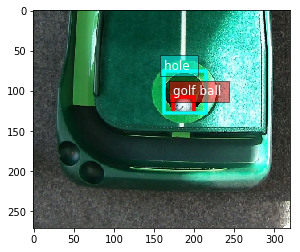

label: [[174.08002  107.97176  200.28235  128.0753     0.      ]
 [163.01176   75.82118  215.19058  127.397644   1.      ]]


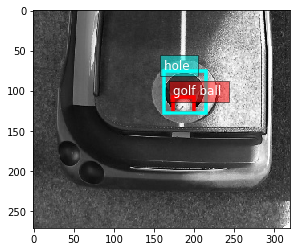

label: [[174.08002  107.97176  200.28235  128.0753     0.      ]
 [163.01176   75.82118  215.19058  127.397644   1.      ]]


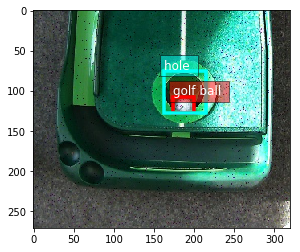

label: [[174.08002  107.97176  200.28235  128.0753     0.      ]
 [163.01176   75.82118  215.19058  127.397644   1.      ]]


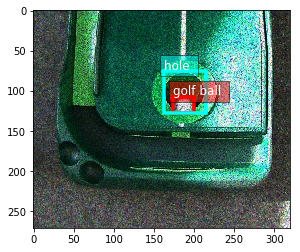

label: [[174.08002  107.97176  200.28235  128.0753     0.      ]
 [163.01176   75.82118  215.19058  127.397644   1.      ]]


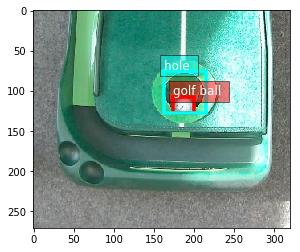

label: [[174.08002  107.97176  200.28235  128.0753     0.      ]
 [163.01176   75.82118  215.19058  127.397644   1.      ]]


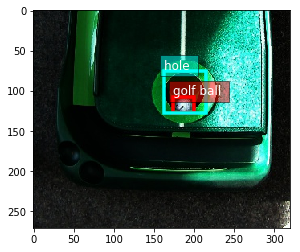

label: [[218.20236  118.437645 250.65413  151.71765    0.      ]
 [ 18.352942 163.6706    49.035297 195.95294    0.      ]
 [150.9647    79.35999  205.55295  131.23766    1.      ]]


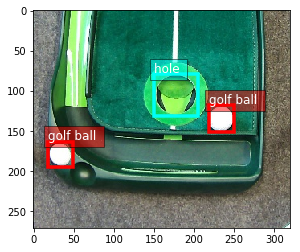

label: [[218.20236  118.437645 250.65413  151.71765    0.      ]
 [ 18.352942 163.6706    49.035297 195.95294    0.      ]
 [150.9647    79.35999  205.55295  131.23766    1.      ]]


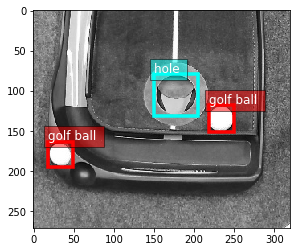

label: [[218.20236  118.437645 250.65413  151.71765    0.      ]
 [ 18.352942 163.6706    49.035297 195.95294    0.      ]
 [150.9647    79.35999  205.55295  131.23766    1.      ]]


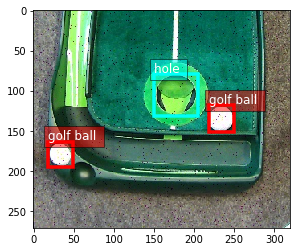

label: [[218.20236  118.437645 250.65413  151.71765    0.      ]
 [ 18.352942 163.6706    49.035297 195.95294    0.      ]
 [150.9647    79.35999  205.55295  131.23766    1.      ]]


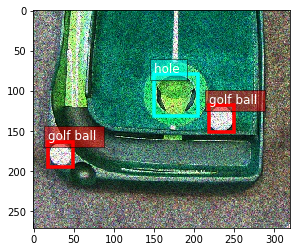

label: [[218.20236  118.437645 250.65413  151.71765    0.      ]
 [ 18.352942 163.6706    49.035297 195.95294    0.      ]
 [150.9647    79.35999  205.55295  131.23766    1.      ]]


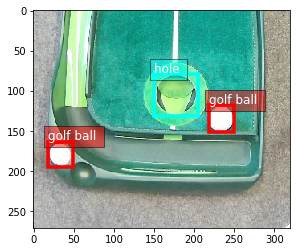

label: [[218.20236  118.437645 250.65413  151.71765    0.      ]
 [ 18.352942 163.6706    49.035297 195.95294    0.      ]
 [150.9647    79.35999  205.55295  131.23766    1.      ]]


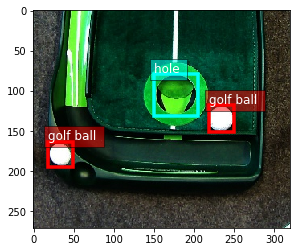

label: [[192.60236  67.53882 225.05411 101.64706   0.     ]
 [ 50.44706 221.49019  80.43922 253.11372   0.     ]
 [117.23294  71.98118 173.47765 127.47294   1.     ]]


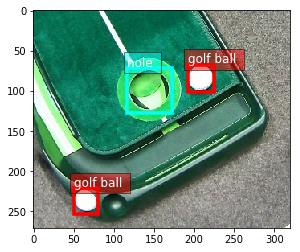

label: [[192.60236  67.53882 225.05411 101.64706   0.     ]
 [ 50.44706 221.49019  80.43922 253.11372   0.     ]
 [117.23294  71.98118 173.47765 127.47294   1.     ]]


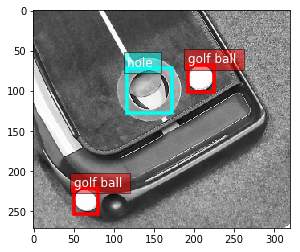

label: [[192.60236  67.53882 225.05411 101.64706   0.     ]
 [ 50.44706 221.49019  80.43922 253.11372   0.     ]
 [117.23294  71.98118 173.47765 127.47294   1.     ]]


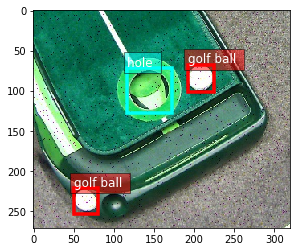

label: [[192.60236  67.53882 225.05411 101.64706   0.     ]
 [ 50.44706 221.49019  80.43922 253.11372   0.     ]
 [117.23294  71.98118 173.47765 127.47294   1.     ]]


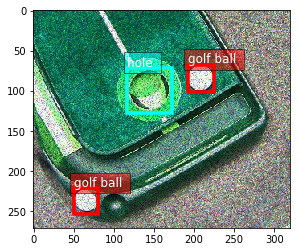

label: [[192.60236  67.53882 225.05411 101.64706   0.     ]
 [ 50.44706 221.49019  80.43922 253.11372   0.     ]
 [117.23294  71.98118 173.47765 127.47294   1.     ]]


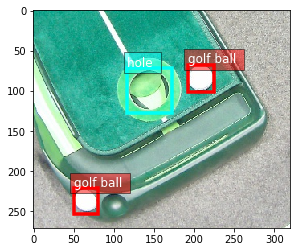

label: [[192.60236  67.53882 225.05411 101.64706   0.     ]
 [ 50.44706 221.49019  80.43922 253.11372   0.     ]
 [117.23294  71.98118 173.47765 127.47294   1.     ]]


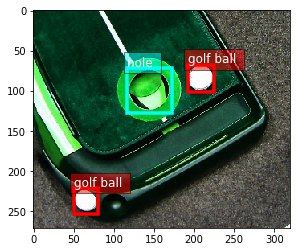

label: [[ 91.03059   63.02118  124.76235   98.183525   0.      ]
 [ 17.317646 162.13333   47.937256 197.1451     0.      ]
 [150.21176   79.73647  204.72472  131.46353    1.      ]]


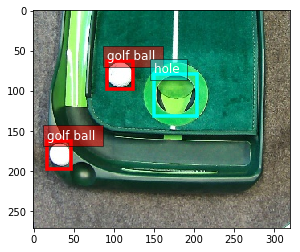

label: [[ 91.03059   63.02118  124.76235   98.183525   0.      ]
 [ 17.317646 162.13333   47.937256 197.1451     0.      ]
 [150.21176   79.73647  204.72472  131.46353    1.      ]]


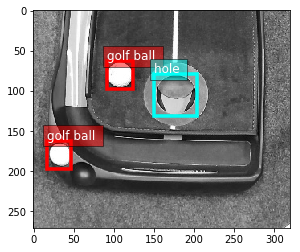

label: [[ 91.03059   63.02118  124.76235   98.183525   0.      ]
 [ 17.317646 162.13333   47.937256 197.1451     0.      ]
 [150.21176   79.73647  204.72472  131.46353    1.      ]]


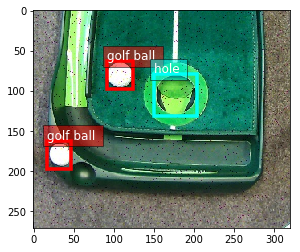

label: [[ 91.03059   63.02118  124.76235   98.183525   0.      ]
 [ 17.317646 162.13333   47.937256 197.1451     0.      ]
 [150.21176   79.73647  204.72472  131.46353    1.      ]]


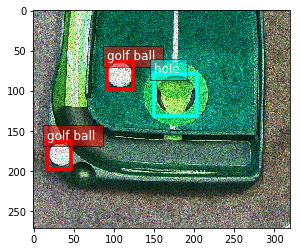

label: [[ 91.03059   63.02118  124.76235   98.183525   0.      ]
 [ 17.317646 162.13333   47.937256 197.1451     0.      ]
 [150.21176   79.73647  204.72472  131.46353    1.      ]]


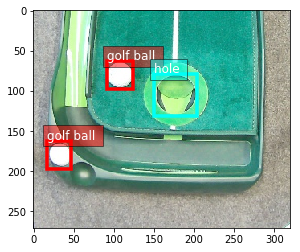

label: [[ 91.03059   63.02118  124.76235   98.183525   0.      ]
 [ 17.317646 162.13333   47.937256 197.1451     0.      ]
 [150.21176   79.73647  204.72472  131.46353    1.      ]]


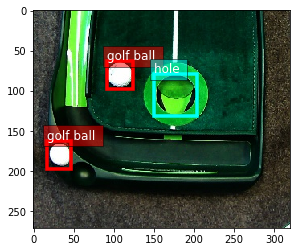

label: [[223.84941 155.85883 259.23764 187.33176   0.     ]
 [158.41882  72.05647 217.75058 133.04471   1.     ]]


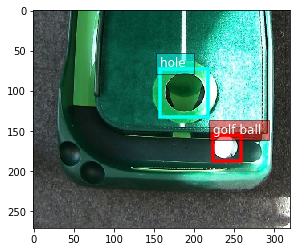

label: [[223.84941 155.85883 259.23764 187.33176   0.     ]
 [158.41882  72.05647 217.75058 133.04471   1.     ]]


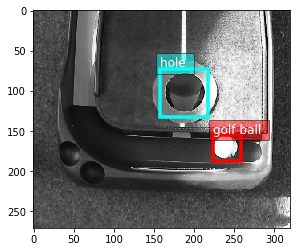

label: [[223.84941 155.85883 259.23764 187.33176   0.     ]
 [158.41882  72.05647 217.75058 133.04471   1.     ]]


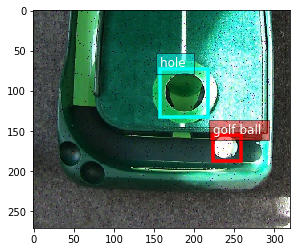

label: [[223.84941 155.85883 259.23764 187.33176   0.     ]
 [158.41882  72.05647 217.75058 133.04471   1.     ]]


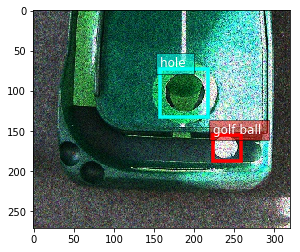

label: [[223.84941 155.85883 259.23764 187.33176   0.     ]
 [158.41882  72.05647 217.75058 133.04471   1.     ]]


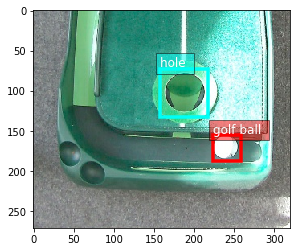

label: [[223.84941 155.85883 259.23764 187.33176   0.     ]
 [158.41882  72.05647 217.75058 133.04471   1.     ]]


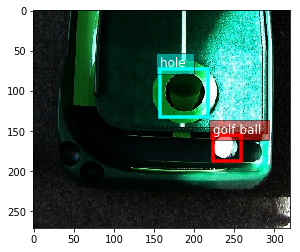

In [26]:
dataset = gcv.data.RecordFileDetection('all.rec')
classes = ['golf ball', 'hole']  # only one foreground class here
for i in range(30):
    image, label = dataset[i]
    print('label:', label)
    # display image and label
    ax = viz.plot_bbox(image, bboxes=label[:, :4], labels=label[:, 4:5], class_names=classes)
    plt.show()

In [27]:
net = gcv.model_zoo.get_model('yolo3_darknet53_voc', pretrained=True)

Model file is not found. Downloading.


223070KB [00:12, 17432.25KB/s]                            


In [28]:
net.reset_class(classes)

In [33]:
from mxnet import autograd, gluon
import mxnet as mx

def get_dataloader(net, train_dataset, data_shape, batch_size, num_workers):
    from gluoncv.data.batchify import Tuple, Stack, Pad
    from gluoncv.data.transforms.presets.ssd import SSDDefaultTrainTransform
    width, height = data_shape, data_shape
    # use fake data to generate fixed anchors for target generation
    with autograd.train_mode():
        #_, _, _, _, anchors = net(mx.nd.zeros((1, 3, height, width)))
        print(net(mx.nd.zeros((1, 3, height, width))))
    batchify_fn = Tuple(Stack(), Stack(), Stack())  # stack image, cls_targets, box_targets
    train_loader = gluon.data.DataLoader(
        train_dataset.transform(SSDDefaultTrainTransform(width, height, anchors)),
        batch_size, True, batchify_fn=batchify_fn, last_batch='rollover', num_workers=num_workers)
    return train_loader

train_data = get_dataloader(net, dataset, 320, 16, 0)

(
[[[ -39.53557   -25.064436   57.472626   68.128174]
  [-138.92648  -132.75398   168.82544   158.11977 ]
  [-136.0559    -68.27979   147.78777    91.65446 ]
  ...
  [ 312.52295   306.75195   317.8888    324.45038 ]
  [ 306.34344   306.29584   323.625     325.4591  ]
  [ 307.97406   306.09244   326.56464   327.9476  ]]]
<NDArray 1x6300x4 @cpu(0)>, [
[[[[116.  90.]
   [156. 198.]
   [373. 326.]]]]
<NDArray 1x1x3x2 @cpu(0)>, 
[[[[ 30.  61.]
   [ 62.  45.]
   [ 59. 119.]]]]
<NDArray 1x1x3x2 @cpu(0)>, 
[[[[10. 13.]
   [16. 30.]
   [33. 23.]]]]
<NDArray 1x1x3x2 @cpu(0)>], [
[[[[0. 0.]]

  [[1. 0.]]

  [[2. 0.]]

  [[3. 0.]]

  [[4. 0.]]

  [[5. 0.]]

  [[6. 0.]]

  [[7. 0.]]

  [[8. 0.]]

  [[9. 0.]]

  [[0. 1.]]

  [[1. 1.]]

  [[2. 1.]]

  [[3. 1.]]

  [[4. 1.]]

  [[5. 1.]]

  [[6. 1.]]

  [[7. 1.]]

  [[8. 1.]]

  [[9. 1.]]

  [[0. 2.]]

  [[1. 2.]]

  [[2. 2.]]

  [[3. 2.]]

  [[4. 2.]]

  [[5. 2.]]

  [[6. 2.]]

  [[7. 2.]]

  [[8. 2.]]

  [[9. 2.]]

  [[0. 3.]]

  [[1. 3.]]

  [[2. 3

NameError: name 'anchors' is not defined

In [17]:
num_gpus = -1
is_gpus = False

for i in range(128):
    try:
        a = mx.nd.zeros((1,), ctx=mx.gpu(i))
        num_gpus = i + 1
        is_gpus = True
    except:
        print("GPU: " + str(num_gpus))
        break

if is_gpus:
    ctx = [mx.gpu(i) for i in range(num_gpus)]
    #print(ctx)
else:
    print("Fallback to CPU")
    ctx = [mx.cpu()]

GPU: 4


In [ ]:
net.collect_params().reset_ctx(ctx)
trainer = gluon.Trainer(
    net.collect_params(), 'sgd',
    {'learning_rate': 0.001, 'wd': 0.0005, 'momentum': 0.9})

mbox_loss = gcv.loss.SSDMultiBoxLoss()
ce_metric = mx.metric.Loss('CrossEntropy')
smoothl1_metric = mx.metric.Loss('SmoothL1')

for epoch in range(0, 5):
    ce_metric.reset()
    smoothl1_metric.reset()
    tic = time.time()
    btic = time.time()
    net.hybridize(static_alloc=True, static_shape=True)
    for i, batch in enumerate(train_data):
        batch_size = batch[0].shape[0]
        data = gluon.utils.split_and_load(batch[0], ctx_list=ctx, batch_axis=0)
        cls_targets = gluon.utils.split_and_load(batch[1], ctx_list=ctx, batch_axis=0)
        box_targets = gluon.utils.split_and_load(batch[2], ctx_list=ctx, batch_axis=0)
        with autograd.record():
            cls_preds = []
            box_preds = []
            for x in data:
                cls_pred, box_pred, _ = net(x)
                cls_preds.append(cls_pred)
                box_preds.append(box_pred)
            sum_loss, cls_loss, box_loss = mbox_loss(
                cls_preds, box_preds, cls_targets, box_targets)
            autograd.backward(sum_loss)
        # since we have already normalized the loss, we don't want to normalize
        # by batch-size anymore
        trainer.step(1)
        ce_metric.update(0, [l * batch_size for l in cls_loss])
        smoothl1_metric.update(0, [l * batch_size for l in box_loss])
        name1, loss1 = ce_metric.get()
        name2, loss2 = smoothl1_metric.get()
        if i % 20 == 0:
            print('[Epoch {}][Batch {}], Speed: {:.3f} samples/sec, {}={:.3f}, {}={:.3f}'.format(
                epoch, i, batch_size/(time.time()-btic), name1, loss1, name2, loss2))
        btic = time.time()

[Epoch 0][Batch 0], Speed: 3.275 samples/sec, CrossEntropy=11.101, SmoothL1=1.350
[Epoch 0][Batch 20], Speed: 20.020 samples/sec, CrossEntropy=5.111, SmoothL1=1.024
[Epoch 0][Batch 40], Speed: 21.280 samples/sec, CrossEntropy=3.890, SmoothL1=0.877
[Epoch 0][Batch 60], Speed: 20.567 samples/sec, CrossEntropy=3.301, SmoothL1=0.794
[Epoch 0][Batch 80], Speed: 19.005 samples/sec, CrossEntropy=2.938, SmoothL1=0.743
[Epoch 0][Batch 100], Speed: 21.673 samples/sec, CrossEntropy=2.695, SmoothL1=0.694
[Epoch 0][Batch 120], Speed: 18.713 samples/sec, CrossEntropy=2.521, SmoothL1=0.661
[Epoch 0][Batch 140], Speed: 19.456 samples/sec, CrossEntropy=2.385, SmoothL1=0.636
[Epoch 0][Batch 160], Speed: 18.287 samples/sec, CrossEntropy=2.280, SmoothL1=0.622
[Epoch 0][Batch 180], Speed: 19.027 samples/sec, CrossEntropy=2.193, SmoothL1=0.608
[Epoch 0][Batch 200], Speed: 20.549 samples/sec, CrossEntropy=2.111, SmoothL1=0.590
[Epoch 0][Batch 220], Speed: 19.687 samples/sec, CrossEntropy=2.044, SmoothL1=0.57

In [ ]:
net.save_parameters('yolo3_darknet53_voc_golf' + str(image_shape) + '.params')

In [ ]:
input_folder = "s3://ale-golfball-train/gt-input-small" + str(image_shape)

!aws s3 cp $input_folder/1f62d6d6a29d42d1a34618206608084d.jpeg test1-$image_shape-small.jpeg
!aws s3 cp $input_folder/9b19ea0cf79945c9bbfb6f5d48b7f777.jpeg test2-$image_shape-small.jpeg
!aws s3 cp $input_folder/1e21e78e40c34800ba392612e0a3a784.jpeg test3-$image_shape-small.jpeg

In [ ]:
classes = ['golf ball', 'hole']  # only one foreground class here
net = gcv.model_zoo.get_model('yolo3_darknet53_voc', classes=classes, pretrained_base=False)
net.load_parameters('yolo3_darknet53_voc_golf' + str(image_shape) + '.params')
x, image = gcv.data.transforms.presets.ssd.load_test("test1-" + str(image_shape) + "-small.jpeg", 512)
cid, score, bbox = net(x)

to_del = []
bbox_s = bbox[0]
score_s = score[0]
cid_s = cid[0]

for i in range(len(score[0])-1, -1, -1):
    #print(score[0][i])
    if score[0][i] < 0.25:
        #to_del.append(i)
        bbox[0][i] = -1
        score[0][i] = -1
        cid[0][i] = -1

ax = viz.plot_bbox(image, bbox[0], score[0], cid[0], class_names=classes)
plt.show()

In [ ]:

    print(i)